In [2]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 13314, 'height': 6081, 'count': 1, 'crs': CRS.from_wkt('PROJCS["World_Eckert_IV",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Eckert_IV"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(2541.8487998980077, 0.0, -16921197.840541057,
       0.0, -2541.8678915901482, 8460601.461471582), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


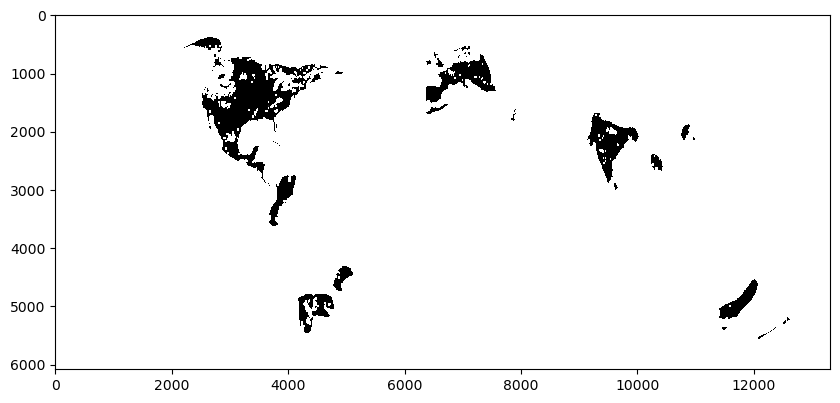

In [3]:
file_path = "amerob/amerob_abundance_median_2022-01-04.tif"
with rasterio.open(file_path) as dataset:
    print(dataset.profile)

    data = dataset.read(1)

    plt.figure(figsize=(10, 10))
    show(data, cmap='gray')
    plt.show()


width of 13,314 pixels and a height of 6,081 pixels.

In [15]:
import rasterio
import pandas as pd
import numpy as np
from rasterio.transform import Affine

# Open the raster file
file_path = "amerob/amerob_abundance_median_2022-01-04.tif"
with rasterio.open(file_path) as dataset:
    data = dataset.read(1)  # Read the first band
    transform = dataset.transform  # Get the affine transform

    # Get the coordinates of each pixel
    rows, cols = np.indices(data.shape)
    xs, ys = rasterio.transform.xy(transform, rows, cols)
    
    # Flatten the arrays
    xs = np.array(xs).flatten()
    ys = np.array(ys).flatten()
    values = data.flatten()

    # Create a DataFrame
    df = pd.DataFrame({
        'x': xs,
        'y': ys,
        'value': values
    })

# Display the DataFrame
df




,x,y,value
0,-1.691993e+07,8.459331e+06,NaN
1,-1.691739e+07,8.459331e+06,NaN
2,-1.691484e+07,8.459331e+06,NaN
3,-1.691230e+07,8.459331e+06,NaN
4,-1.690976e+07,8.459331e+06,NaN
...,...,...,...
80962429,1.690954e+07,-6.995226e+06,NaN
80962430,1.691208e+07,-6.995226e+06,NaN
80962431,1.691462e+07,-6.995226e+06,NaN
80962432,1.691716e+07,-6.995226e+06,NaN


In [23]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import pandas as pd
import numpy as np

# Open the raster file
file_path = "amerob/amerob_abundance_median_2022-01-04.tif"
with rasterio.open(file_path) as src:
    # Reproject to WGS84
    dst_crs = 'EPSG:4326'  # WGS84
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open('reprojected.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

# Now read the reprojected raster and create the DataFrame
with rasterio.open('reprojected.tif') as dataset:
    data = dataset.read(1)  # Read the first band
    transform_affine = dataset.transform  # Get the affine transform

    # Get the coordinates of each pixel
    rows, cols = np.indices(data.shape)
    xs = transform_affine[2] + cols * transform_affine[0] + rows * transform_affine[1]
    ys = transform_affine[5] + cols * transform_affine[3] + rows * transform_affine[4]
    
    # Flatten the arrays
    xs = xs.flatten()
    ys = ys.flatten()
    values = data.flatten()

    # Create a DataFrame
    df = pd.DataFrame({
        'longitude': xs,
        'latitude': ys,
        'value': values
    })

# Display the DataFrame
df


,longitude,latitude,value
0,-180.000000,90.000000,NaN
1,-179.973355,90.000000,NaN
2,-179.946710,90.000000,NaN
3,-179.920065,90.000000,NaN
4,-179.893420,90.000000,NaN
...,...,...,...
76066925,179.866775,-59.984462,NaN
76066926,179.893420,-59.984462,NaN
76066927,179.920065,-59.984462,NaN
76066928,179.946710,-59.984462,NaN


In [24]:
# Python code to filter the DataFrame based on given latitude and longitude range and replace NaN with 0

# Filter the DataFrame based on the specified latitude and longitude range
filtered_df = df[
    (df['latitude'] >= 24.75) & (df['latitude'] <= 49.25) &
    (df['longitude'] >= -124.75) & (df['longitude'] <= -67.25)
]

# Replace NaN values in the 'value' column with 0
filtered_df['value'].fillna(0, inplace=True)

# Display the filtered DataFrame
filtered_df


C:\Users\Matin\AppData\Local\Temp\ipykernel_48316\3551934480.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['value'].fillna(0, inplace=True)


,longitude,latitude,value
20673904,-124.738361,49.233216,0.000000
20673905,-124.711716,49.233216,0.000000
20673906,-124.685071,49.233216,0.000000
20673907,-124.658426,49.233216,0.000000
20673908,-124.631782,49.233216,4.813247
...,...,...,...
33079155,-67.371771,24.773146,0.000000
33079156,-67.345126,24.773146,0.000000
33079157,-67.318481,24.773146,0.000000
33079158,-67.291836,24.773146,0.000000


In [26]:
data = filtered_df.pivot_table(index='latitude', columns='longitude', values='value', aggfunc='mean')
data

longitude,-124.738361,-124.711716,-124.685071,-124.658426,-124.631782,-124.605137,-124.578492,-124.551847,-124.525202,-124.498557,...,-67.504996,-67.478351,-67.451706,-67.425061,-67.398416,-67.371771,-67.345126,-67.318481,-67.291836,-67.265191
latitude,,,,,,,,,,,,,,,,,,,,,
24.773146,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24.799790,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24.826435,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24.853080,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24.879725,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49.126636,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49.153281,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49.179926,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
